Rao's model for solid solution hardening in BCC alloy.

https://doi.org/10.1016/j.actamat.2019.02.013

In [99]:
from sympy import *
import numpy as np
import math
import sympy
import matplotlib.pyplot as plt
from IPython.display import clear_output
from random import randrange

In [298]:
class rao_model():
    def __init__(self, mu, b, E, c, k, T, v, epsilon, u, k_, comment='None'):
        super(rao_model, self).__init__()
        self.mu = mu
        self.b = b
        self.E = E
        self.c = c
        self.k = k 
        self.T = T
        self.a = 0.942*b 
        self.lamda = 10*b 
        self.v = v
        self.epsilon = epsilon 
        self.u = u
        self.k_ = k_
        self.comment = comment

    def softmax(self, x):
        f_x = np.exp(x) / np.sum(np.exp(x))
        return f_x

    def f1(self):
        tao_chose_list = []
        for index in range(len(self.c)):
            mu_, c_, E_ = self.mu[index], self.c[index], self.E[index]
            tao_k = Symbol('tao_k', real=True)
            #*deltaV
            v_lefttop = 3*(self.k_**2)*(E_**2)*c_
            v_leftbot = 2*(tao_k**2)*self.a*(self.b**2)
            v_righttop = tao_k**2*(self.a**3)*(self.b**4)*(self.lamda**2)
            v_rightbot = 6*(self.k_**2)*(E_**2)*c_

            v_ = v_lefttop/v_leftbot + v_righttop/v_rightbot

            #*S
            s_lefttop = 18*(self.k_**2)*(E_**2)*c_*self.k*self.T
            s_leftbot = self.a**3*(self.b**4)*(self.lamda**2)
            s_righttop = (5*math.pi*self.k*self.T)**2*self.v*self.a*self.b
            s_rightbot = (mu_*self.b*v_)**2*self.epsilon

            s_ = s_lefttop/s_leftbot*sympy.log(s_righttop/s_rightbot)

            #*R
            r_top = 27*(self.k_**4)*(E_**4)*(c_**2)
            r_bot = (self.a**4)*(self.b**6)*(self.lamda**2)

            r_ = r_top/r_bot

            #*tao_k
            f1_ = tao_k**4 + s_*tao_k - r_bot
            res_list, tao_list = [], []
            tao_k_c = 2e8
            temp = 1e5
            speed = 1e9
            step = 0

            while True:
                f1_res = abs(f1_.subs(tao_k, tao_k_c))
                res_list.append(abs(f1_res.evalf()))
                tao_list.append(tao_k_c)
                tao_chose = tao_k_c
                tao_chose += (np.random.rand()-0.5)*speed
                f1_res_ = abs(f1_.subs(tao_k, tao_chose))
                res = (f1_res - f1_res_).evalf()

                accep = np.random.rand()
                prob_ = np.min([1, exp(res/temp)])
                if accep <= prob_:
                    tao_k_c = tao_chose

                temp /= 1.1
                speed /= 1.2

                # if step % 10 == 0:
                    # clear_output(True)

                    # fig, (ax1, ax2) = plt.subplots(1, 2)
                    # ax1.plot(res_list)
                    # ax1.set_ylim([1e7, 1e9])
                    # ax2.plot(tao_list)
                    # plt.suptitle(f'Num steps: {step}, Minimum res: {f1_res}\n{tao_chose/1e6} MPa')
                    # plt.suptitle(f'Num steps: {step}, Minimum res: {np.min(res_list)}\n{tao_chose/1e6} MPa')
                    # plt.show()

                step += 1
                if step >= 888:
                    tao_chose_list.append(tao_chose)
                    break
                
        return np.array(tao_chose_list)

    def f4(self):
        j_list = []
        for index in range(len(self.c)):
            mu_, c_, E_ = self.mu[index], self.c[index], self.E[index]
            x = Symbol('x')
            inte_ = sympy.exp(-x**2/2)
            f4_ = 1/sympy.sqrt(2*math.pi)*integrate(inte_, (x, self.k_, oo))
            L_ = self.b/(f4_*3*c_)
            j_ = mu_*self.b/(4*L_)
            j_list.append(j_.evalf())

        return np.array(j_list)

    def tao(self):
        return (self.f1()+self.f4())*self.u

    def ys(self, tf, q):
        tao_list = self.tao()
        ys_ = np.sum(tao_list**(1/q))**q
        if self.comment != 'None':
            print(self.comment)
        return ys_.evalf()*tf

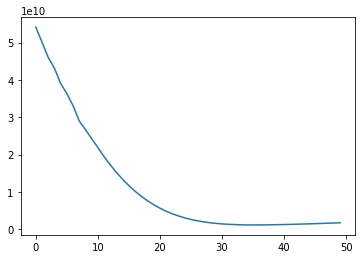

nb 1170.48673015734 Mpa


In [357]:
mo_mu, nb_mu, ta_mu, w_mu = np.array([20, 38, 67, 161])*1e9

mu_list = np.array([20, 38, 67, 161])*1e9 #*Shear modulus, Gpa -> Pa
b = 2.7886e-10 #*Burgers vector of the a/2[111] screw dislocation, m
E = np.array([0.025, -0.074, -0.035, 0.059])*1.6022e-19 #*E_int for a particular atom specie, J, kg m^2 s^-2
c = np.array([1/4, 1/4, 1/4, 1/4]) #*Atomic concentration
k = 8.617e-5 #*Boltzmann constant, in eV form
k = 1.380649e-23 #*Standard form, m^2 kg s^-2 k^-1
T = 293 #*Temperature, K
v = 5e12 #*Debye frequency, s^-1
epsilon = 1e-3 #*Strain rate, s^-1
u = 1 #*Unit convertion to Pa, kg m^-1 s^-2

#*Searching for the best k and minimum tao_i
ys_list, list_, k_list = [], [], []
for k_latent in np.linspace(0.1, 5, 60):
    print(f'step: {k_latent}')
    rao_model_ = rao_model(mu_list, b, E, c, k, T, v, epsilon, u, k_latent, 'MoNbTaW')
    tao_k = rao_model_.ys(3.067, 2/3)
    list_.append(tao_k)
    k_list.append(k_latent)
    clear_output(True)
    try:
        plt.plot(list_)
        plt.show()
    except:
        del list_[-1]

print(np.min(np.abs(list_)).evalf()/1e6, 'Mpa')